In [181]:
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 

In [182]:

def make_name(s1,s2): 
    out_name = ""
    if not (pd.isna(s1) and pd.isna(s2)): 
        out_name = "_".join( [e for e in [s1,s2] if not pd.isna(e)])
    return out_name
def filter_columns(col_names,pattern,exclude_capita=True):
    if exclude_capita: 
        return [ e for e in col_names if e.startswith(pattern) and 'capita' not in e]
    else: 
        return [ e for e in col_names if e.startswith(pattern) ]

In [194]:
data = pd.read_excel("./2016cityandcountyenergyprofiles(1).xlsb",sheet_name='County',skiprows=4)
col_info = pd.read_excel("./2016cityandcountyenergyprofiles(1).xlsb",sheet_name='County',nrows=4)
#use this to tell if its residential, industrial or other 
column_identity = col_info.iloc[[0,1],:]
#iterate through all the column names and make them be "residential_consumpition","industrial_consumption" etc 
name_cats = list() 
for col_names in col_info:
    col = col_info[col_names] 
    n1 = col.iloc[0] 
    n2 = col.iloc[1] 
    new_name = make_name(n1,n2)
    name_cats.append(new_name)
#define the actual new neames

new_name = [ f"{a}_{b}" if a  else b for a,b in zip(name_cats,data.keys().to_list()) ] 
#replace the column names 
data.columns = new_name

In [195]:
doe_map = {e['state_id']:e['doe_climate_zone'] for i,e in data.iterrows()}

In [196]:
cols = sorted(data.keys())
reduction_paris = [
    ('Commercial_Electricity_Consume',  filter_columns(cols,'Commercial_Electricity_consumption')),
    ('Commercial_NatrualGas_Consume', filter_columns(cols,'Commercial_Natural Gas_consumption (TcF)')),
    ('Industrial_Electricity_Consume',[e for e in cols if filter_columns(cols,'Industry_Electricity_consumption (MWh)')]),
    ('Industrial_Electricity_Consume',[e for e in cols if filter_columns(cols,'Industry_Electricity_consumption (MWh)')]) ,
    ("Industrial_NaturalGas_Consume",["Industry_Natural Gas_consumption (TcF).3"]),
    ("On Road Disel_Consume",['On Road Transportation_Diesel_consumption (gallons).1']),
    ("On Road Gasoline_Consume",["On Road Transportation_Gasoline_consumption (gallons)"]),
    ("Residential_Electricity_Consume",['Residential_Electricity_consumption (MWh)']),
    ("Residential_NaturalGals_Consume",['Residential_Natural Gas_consumption (TcF)']),
    ]
for n,e in reduction_paris: 
    data[n] = data[e].sum(axis=1)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  


In [209]:
consume_names = [e[0] for e in reduction_paris ]
consume_names= ['Commercial_Electricity_Consume',
 'Commercial_NatrualGas_Consume',
 'Industrial_Electricity_Consume',
 'Industrial_Electricity_Consume',
 'Industrial_NaturalGas_Consume',
 'On Road Disel_Consume',
 'On Road Gasoline_Consume',
 'Residential_Electricity_Consume',
 'Residential_NaturalGals_Consume']

In [199]:
data['total_consume'] = data[[e[0] for e in reduction_paris]].sum(axis=1)

In [200]:
col_name_paris = [
    ('Gasoline of On Road Transportation','On-road Transportation_Gasoline_GHG emissions mtons CO2e.6'),
    ('Diesel of On Road Transportation', 'On-road Transportation_Gasoline_GHG emissions mtons CO2e.6'),
    ('Electricity of Residential','Residential_Electricity_GHG emissions mtons CO2e'),
    ('Natural Gas of Residential', 'Residential_Natural Gas_GHG emissions mtons CO2e.1'),
    ('Electricity Commercial','Commercial_Electricity_GHG emissions mtons CO2e.2'),
    ('Natural Gas Commerical ','Commercial_Natural Gas_GHG emissions mtons CO2e.3'),
    ('Electricity Industry','Industry_Electricity_GHG emissions mtons CO2e.4'),
    ('Natural Gas','Industry_Natural Gas_GHG emissions mtons CO2e.5'),
    ('Total emissions','total_emissions')


]
emi_cols = [e for e in data if 'GHG emissions' in e ] 
data['total_emissions'] = data[emi_cols].sum(axis=1)

In [141]:
import os 
os.makedirs('./figure1_content/',exist_ok=True)

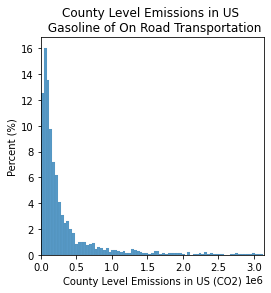

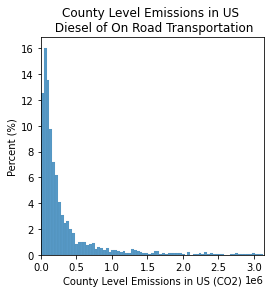

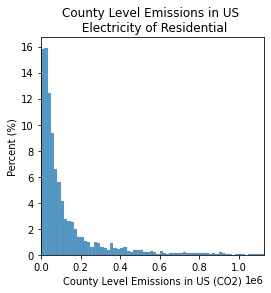

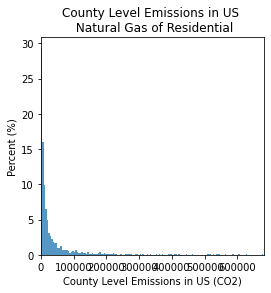

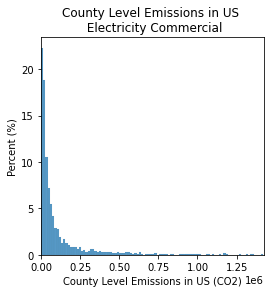

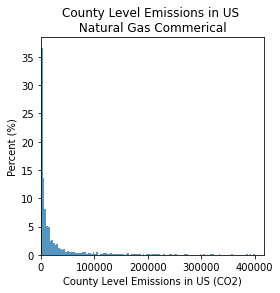

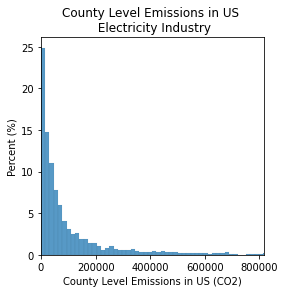

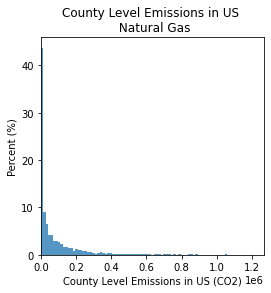

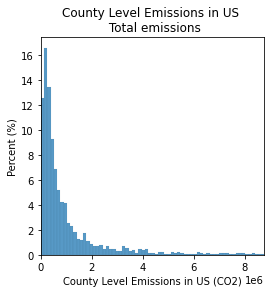

In [143]:
for  i,(name , icol) in enumerate(col_name_paris): 
    plt.figure(figsize=(4,4))
    data_stats=  data[icol].describe()
    mu = data_stats['mean']
    std = data_stats['std']  
    sns.histplot(data=data,x=icol,stat='percent')
    plt.xlim([0, mu + 2*std]) #do this so data is more readable 
    plt.title(f"County Level Emissions in US \n {name}") 
    plt.xlabel("County Level Emissions in US (CO2)")
    plt.ylabel("Percent (%)")
    save_name = name.replace(" ","_")
    plt.savefig(f"./figure1_content/figure1_county_{save_name}_use.png")


In [73]:

os.makedirs('./figure2_content/',exist_ok=True)

In [144]:
climate_map = {1:'Hot\nHumid',2:'Mixed\nHumid',3:'Hot\nDry',4:'Mixed\nDry',5:'Marine',6:'Cold',7:'Very\nCold',8:'Subartic'}
climate_order = [(v,k) for k,v in climate_map.items()] 
climate_order = sorted(climate_order,key=lambda x: x[1])
climate_order = [e[0] for e in climate_order]

In [148]:
data[data['doe_climate_zone_name']=='Subartic']['total_emissions'].mean()

202998.40391509412

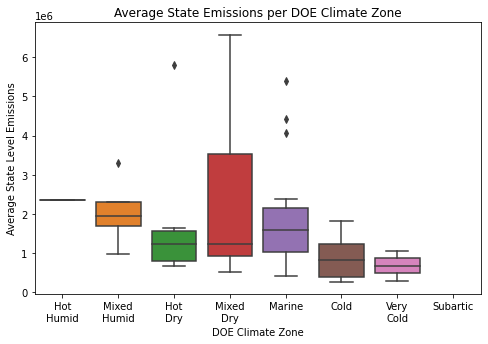

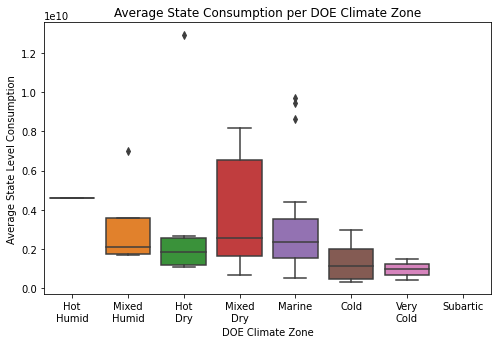

In [204]:

os.makedirs('./figure0_boxplots_overall',exist_ok=True) 
col_name_pairs = [('Emissions','total_emissions'),('Consumption','total_consume')]
for  i,(name , icol) in enumerate(col_name_pairs): 
    plt.figure(figsize=(8,5))
    state_data = data.groupby(by='state_id')
    info = list() 
    for n,e in state_data: 
        s = {} 
        s['state_id'] = n
        s[name]=  e[icol].mean()  
        s['doe_zone']=  climate_map[e['doe_climate_zone'].iloc[0] ]
        info.append(s) 
    plot_df = pd.DataFrame(info)
    sns.boxplot(data=plot_df,x='doe_zone',y=name,order=climate_order)
    plt.title(f"Average State {name} per DOE Climate Zone") 
    plt.ylabel(f"Average State Level {name}")
    plt.xlabel("DOE Climate Zone")
    save_name = name.replace(" ","_")
    plt.savefig(f"./figure0_boxplots_overall/figure0_{save_name}_use_doe.png")

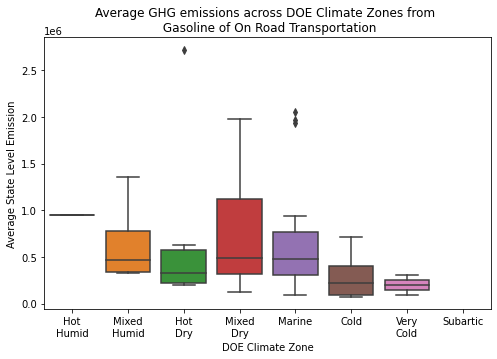

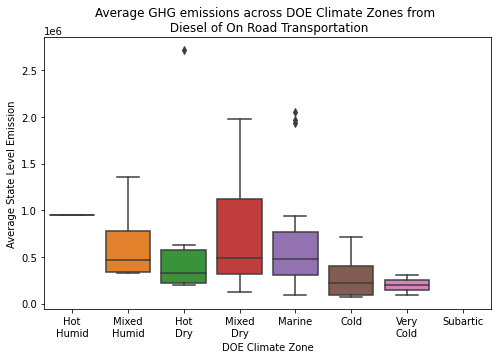

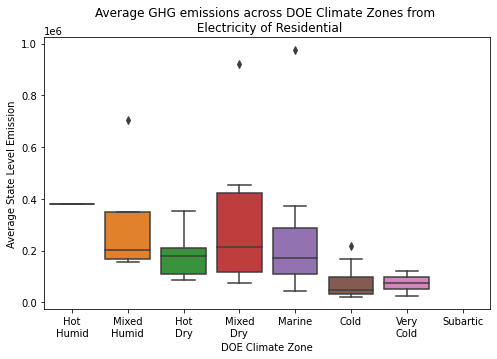

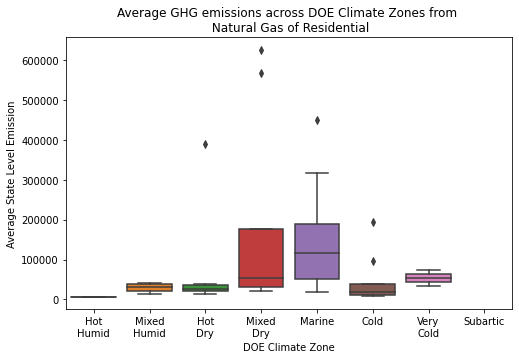

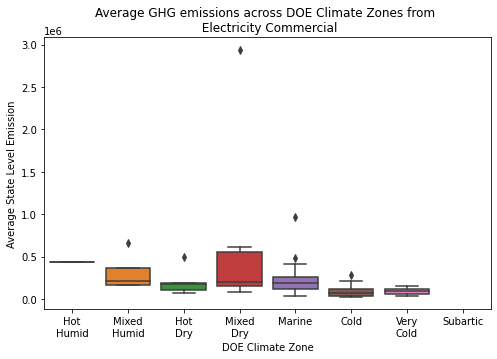

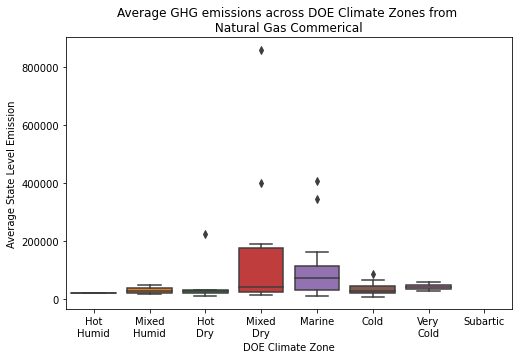

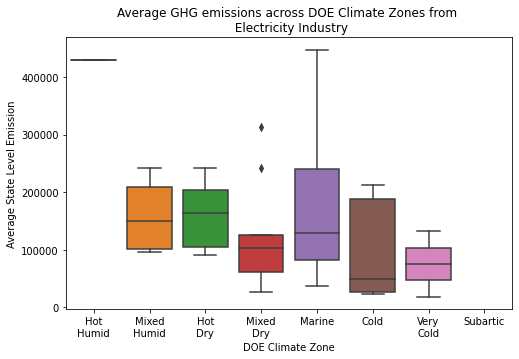

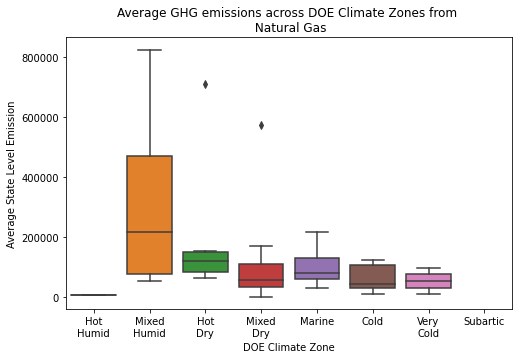

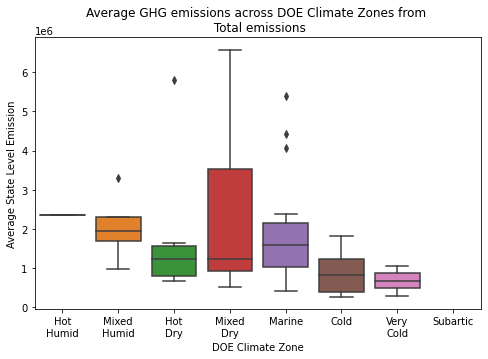

In [206]:
#Do  emisisons plot
for  i,(name , icol) in enumerate(col_name_paris): 
    plt.figure(figsize=(8,5))
    state_data = data.groupby(by='state_id')
    info = list() 
    for n,e in state_data: 
        s = {} 
        s['state_id'] = n
        s['avg_emission']=  e[icol].mean()  
        s['doe_zone']=  climate_map[e['doe_climate_zone'].iloc[0] ]
        info.append(s) 
    plot_df = pd.DataFrame(info)
    sns.boxplot(data=plot_df,x='doe_zone',y='avg_emission',order=climate_order)
    plt.title(f"Average GHG emissions across DOE Climate Zones from \n {name}") 
    plt.ylabel("Average State Level Emission")
    plt.xlabel("DOE Climate Zone")
    save_name = name.replace(" ","_")
    plt.savefig(f"./figure2_content/figure2_county_{save_name}_use_doe.png")



In [212]:
consume_names

['Commercial_Electricity_Consume',
 'Commercial_NatrualGas_Consume',
 'Industrial_Electricity_Consume',
 'Industrial_Electricity_Consume',
 'Industrial_NaturalGas_Consume',
 'On Road Disel_Consume',
 'On Road Gasoline_Consume',
 'Residential_Electricity_Consume',
 'Residential_NaturalGals_Consume']

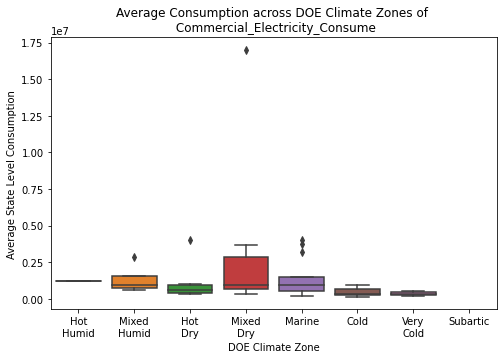

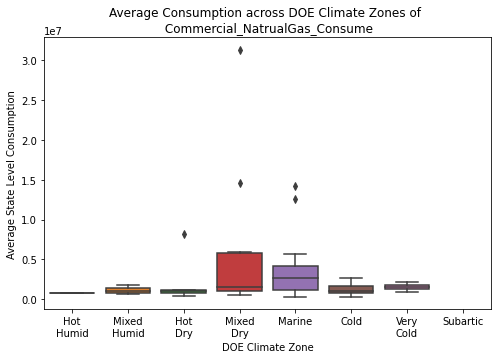

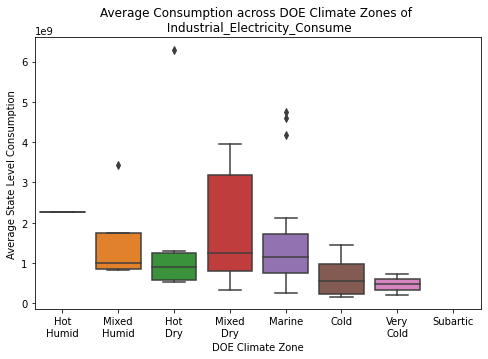

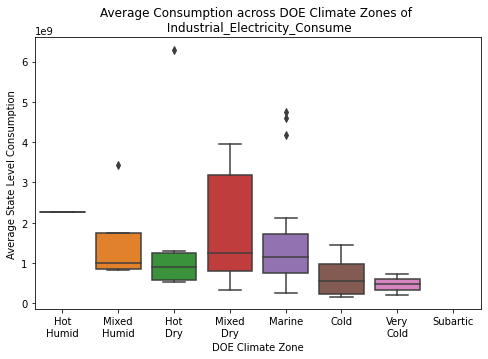

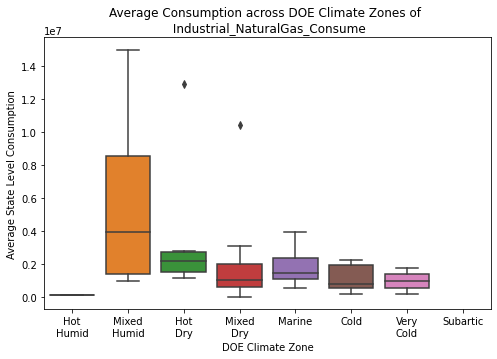

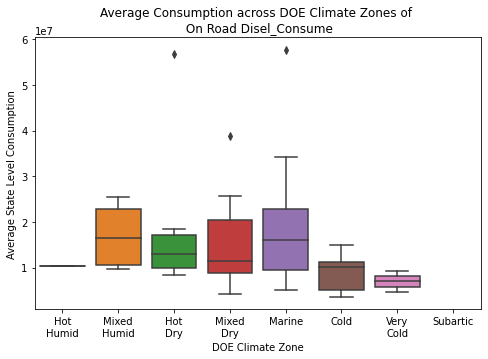

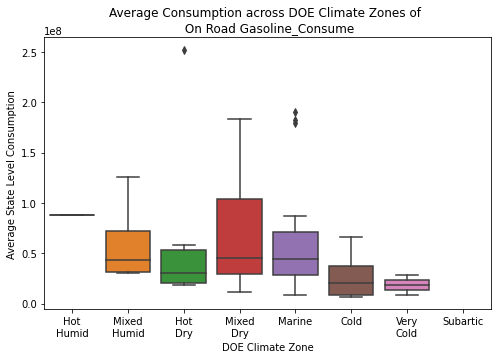

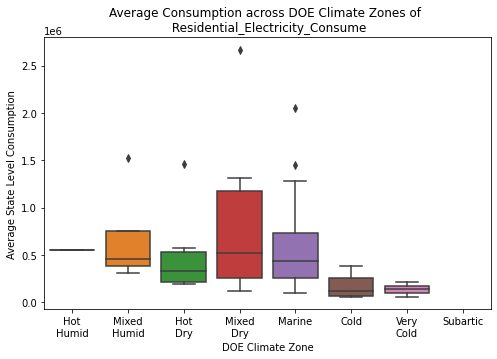

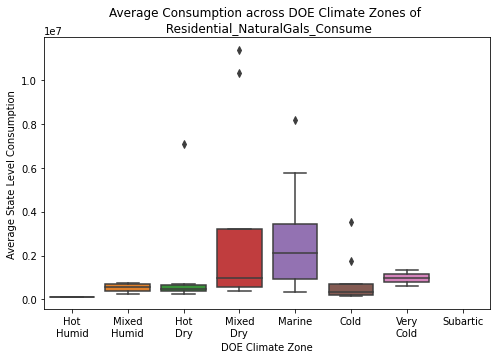

In [214]:
#do consume plot 

os.makedirs('./figure_consumption_per_doe/')
for  i,( icol) in enumerate(consume_names): 
    name = icol
    plt.figure(figsize=(8,5))
    state_data = data.groupby(by='state_id')
    info = list() 
    for n,e in state_data: 
        s = {} 
        s['state_id'] = n
        s[name]=  e[icol].mean()  
        s['doe_zone']=  climate_map[e['doe_climate_zone'].iloc[0] ]
        info.append(s) 
    plot_df = pd.DataFrame(info)
    sns.boxplot(data=plot_df,x='doe_zone',y=name,order=climate_order)
    plt.title(f"Average Consumption across DOE Climate Zones of \n {name}") 
    plt.ylabel("Average State Level Consumption")
    plt.xlabel("DOE Climate Zone")
    save_name = name.replace(" ","_")
    plt.savefig(f"./figure_consumption_per_doe/doe_consumption_{save_name}.png")


In [92]:
len(climate_order)

8

In [138]:
data[emi_cols].sum(axis=1)

0       8.623263e+05
1       3.205665e+06
2       5.796080e+05
3       2.697611e+05
4       7.133495e+05
            ...     
3137    2.870049e+06
3138    4.098668e+05
3139    7.162855e+05
3140    3.593647e+05
3141    4.086348e+05
Length: 3142, dtype: float64

In [109]:
from itertools import combinations
import scipy.stats as stats 
import numpy as np 

In [106]:

data['doe_climate_zone_name'] = data['doe_climate_zone'].map(climate_map)

In [150]:
os.makedirs("./figure3_ranksumtests_emissions",exist_ok=True)

In [156]:
icol

'total_emissions'

In [160]:
combi = combinations(climate_order,2)  
region_comp = list() 
values =list() 
icol = 'total_emissions'
for regiona,regionb in combi:  
    region_comp.append(f"{regiona}_{regionb}")
    ra_val = data.loc[data['doe_climate_zone_name']==regiona,icol]
    rb_val = data.loc[data['doe_climate_zone_name']==regionb,icol]
    pval = stats.ranksums(ra_val,rb_val).pvalue 
    values.append(pval)
overall_comparison =  pd.DataFrame({'Comparison':region_comp,'P-Value':values})
overall_comparison['Comparison'] = overall_comparison['Comparison'].apply(lambda x: x.replace("\n",""))
overall_comparison.sort_values(by='Comparison')

,Comparison,P-Value
26,Cold_Subartic,2.240876e-03
25,Cold_VeryCold,3.627838e-05
15,HotDry_Cold,4.450862e-12
14,HotDry_Marine,8.320229e-01
13,HotDry_MixedDry,3.403880e-02
17,HotDry_Subartic,1.597559e-04
16,HotDry_VeryCold,3.240203e-16
4,HotHumid_Cold,4.884557e-03
1,HotHumid_HotDry,3.137712e-02
3,HotHumid_Marine,4.378528e-02


In [169]:
combi = combinations(climate_order,2)  
region_comp = list() 
values =list() 
icol = 'total_consume'
for regiona,regionb in combi:  
    region_comp.append(f"{regiona}_{regionb}")
    ra_val = data.loc[data['doe_climate_zone_name']==regiona,icol]
    rb_val = data.loc[data['doe_climate_zone_name']==regionb,icol]
    pval = stats.ranksums(ra_val,rb_val).pvalue 
    values.append(pval)
overall_comparison =  pd.DataFrame({'Comparison':region_comp,'P-Value':values})
overall_comparison['Comparison'] = overall_comparison['Comparison'].apply(lambda x: x.replace("\n",""))
overall_comparison.sort_values(by='Comparison')

,Comparison,P-Value
26,Cold_Subartic,7.374015e-04
25,Cold_VeryCold,1.204328e-04
15,HotDry_Cold,4.816769e-15
14,HotDry_Marine,1.043098e-01
13,HotDry_MixedDry,4.962775e-04
17,HotDry_Subartic,4.763426e-05
16,HotDry_VeryCold,2.007568e-17
4,HotHumid_Cold,1.614683e-03
1,HotHumid_HotDry,8.529870e-03
3,HotHumid_Marine,1.123648e-02


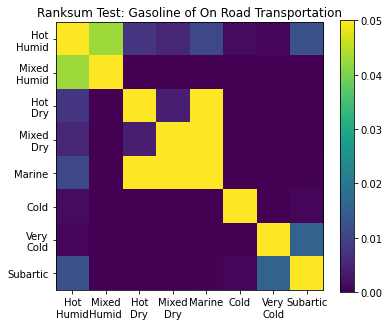

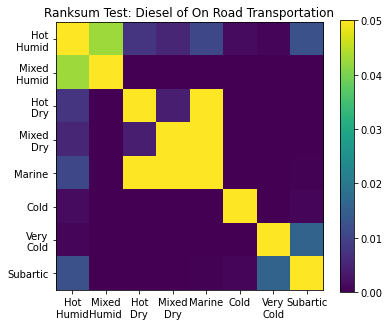

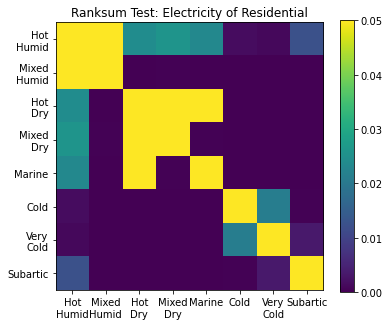

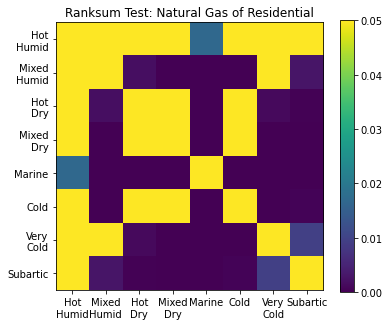

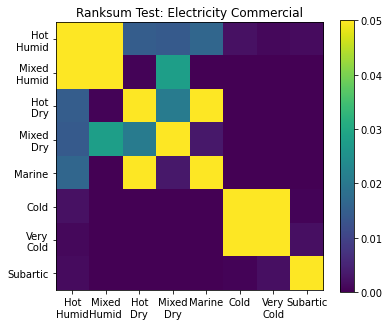

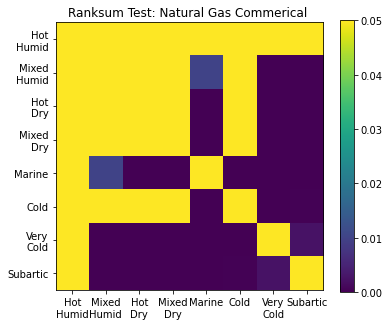

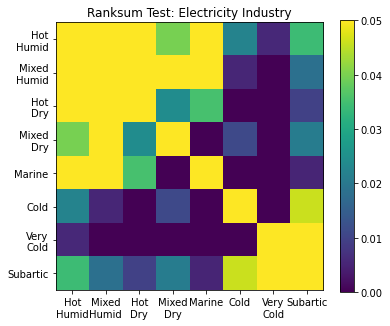

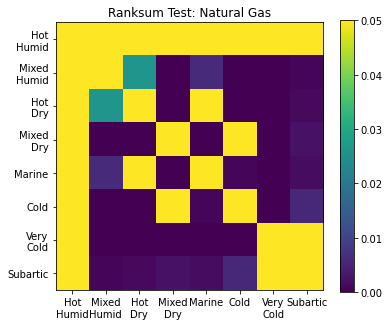

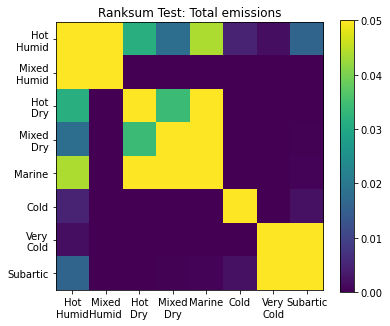

In [155]:
for  i,(name , icol) in enumerate(col_name_paris): 
    names = list()  
    values = list() 
    values = np.zeros((len(climate_order),len(climate_order)))
    for i,regiona in enumerate(climate_order): 
        for j,regionb in enumerate(climate_order): 
            ra_val = data.loc[data['doe_climate_zone_name']==regiona,icol]
            rb_val = data.loc[data['doe_climate_zone_name']==regionb,icol]
            pval = stats.ranksums(ra_val,rb_val).pvalue
            values[i,j] = pval 
    plt.figure(figsize=(6, 5))
    plt.imshow(values, vmin=0, vmax=0.05)
    plt.colorbar()
    save_name = name.replace(" ","_")
    plt.title(f"Ranksum Test: {name}")
    # Add labels
    num_labels = len(climate_order) 
    plt.xticks(range(num_labels),climate_order) 
    plt.yticks(range(num_labels),climate_order)
    plt.savefig(f"./figure3_ranksumtests_emissions/{name}_ranksum.png")


([<matplotlib.axis.YTick at 0x7fa916b38450>,
 [Text(0, 0, 'Hot\nHumid'),
  Text(0, 1, 'Mixed\nHumid'),
  Text(0, 2, 'Hot\nDry'),
  Text(0, 3, 'Mixed\nDry'),
  Text(0, 4, 'Marine'),
  Text(0, 5, 'Cold'),
  Text(0, 6, 'Very\nCold'),
  Text(0, 7, 'Subartic')])

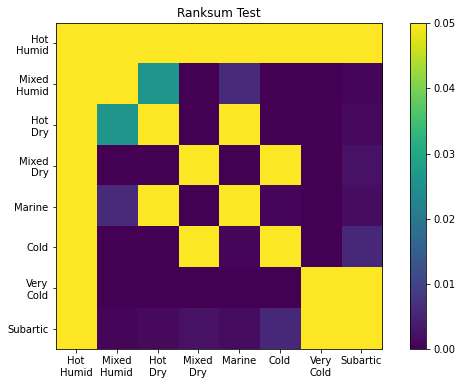

In [ ]:
for  i,(name_x , icol) in enumerate(col_name_paris): 
    for region_a,region_b in climate_combi: 
    plt.figure(figsize=(8,5))
    state_data = data.groupby(by='state_id')
    info = list() 
    for n,e in state_data: 
        s = {} 
        s['state_id'] = n
        s['avg_emission']=  e[icol].mean()  
        s['doe_zone']=  climate_map[e['doe_climate_zone'].iloc[0] ]
        info.append(s) 
    plot_df = pd.DataFrame(info)
    sns.boxplot(data=plot_df,x='doe_zone',y='avg_emission',order=climate_order)
    plt.title(f"Average County emission across state for DOE level from \n {name}") 
    plt.ylabel("Average State Level Emission")
    plt.xlabel("DOE Climate Zone")
    save_name = name.replace(" ","_")
    plt.savefig(f"./figure2_content/figure2_county_{save_name}_use_doe.png")

In [171]:
os.makedirs("./figure4_consumption/",exist_ok=True)

In [173]:
consume_pairs = [e for e in data if 'consume' in e] 
consume_pairs

['total_consume']

In [178]:
consume_cols = ['Commercial_Electricity_Consume',
 'Commercial_NatrualGas_Consume',
 'Industrial_Electricity_Consume',
 'Industrial_Electricity_Consume',
 'Industrial_NaturalGas_Consume',
 'On Road Disel_Consume',
 'On Road Gasoline_Consume',
 'Residential_Electricity_Consume',
 'Residential_NaturalGals_Consume']

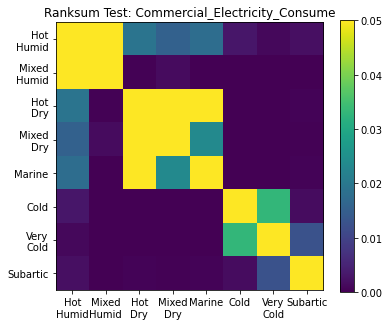

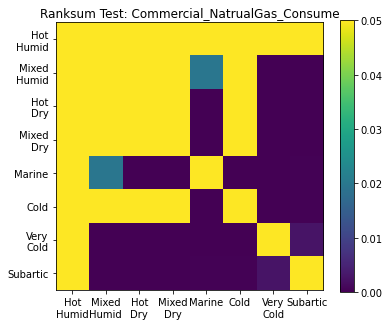

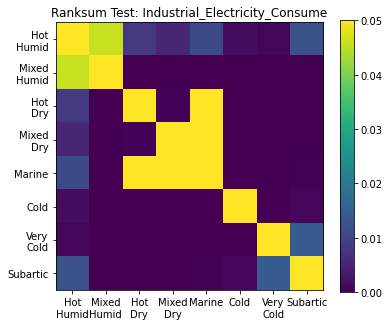

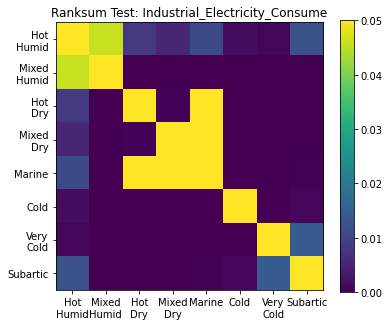

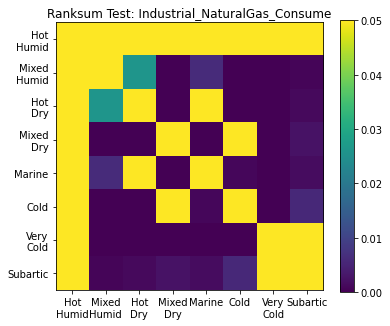

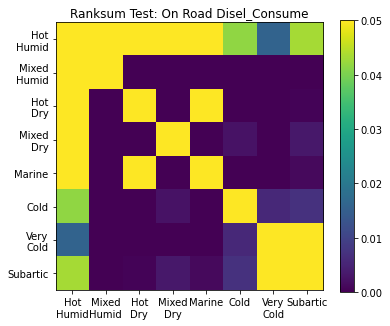

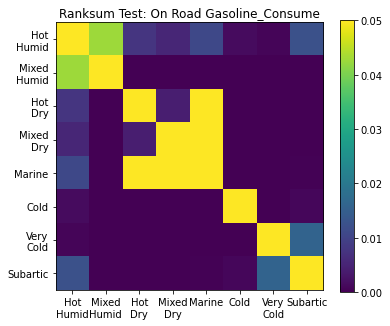

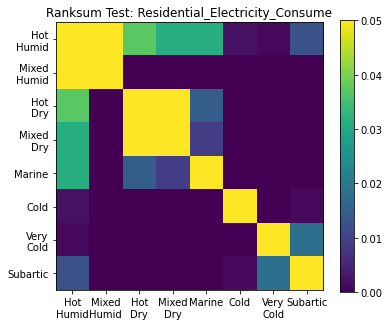

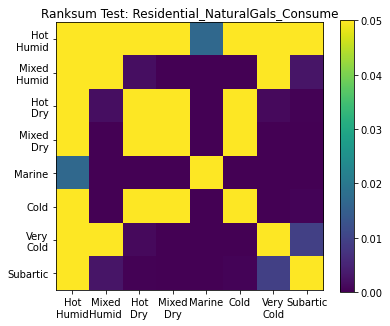

In [179]:
for  i,(icol) in enumerate(consume_cols): 
    name = icol
    names = list()  
    values = list() 
    values = np.zeros((len(climate_order),len(climate_order)))
    for i,regiona in enumerate(climate_order): 
        for j,regionb in enumerate(climate_order): 
            ra_val = data.loc[data['doe_climate_zone_name']==regiona,icol]
            rb_val = data.loc[data['doe_climate_zone_name']==regionb,icol]
            pval = stats.ranksums(ra_val,rb_val).pvalue
            values[i,j] = pval 
    plt.figure(figsize=(6, 5))
    plt.imshow(values, vmin=0, vmax=0.05)
    plt.colorbar()
    save_name = name.replace(" ","_")
    plt.title(f"Ranksum Test: {name}")
    # Add labels
    num_labels = len(climate_order) 
    plt.xticks(range(num_labels),climate_order) 
    plt.yticks(range(num_labels),climate_order)
    plt.savefig(f"./figure4_consumption/{name}_ranksum.png")